In [1]:
# General Information
import os
import datetime
import time

# Tweets
import tweepy
import requests as req

# Pydata
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import seaborn as snb
from scipy import stats
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm
from pandas_datareader import data as web
import statsmodels.formula.api as smf

# Web App
from flask import Flask
import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html
import plotly.figure_factory as ff
import plotly.graph_objs as go

#Natural Language Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

%matplotlib inline

In [2]:
# Tesla stock df build

url_iex_5y='https://api.iextrading.com/1.0/stock/tsla/chart/5y'
response_5y=req.get(url_iex_5y).json()

price_change=[]
price_changeperc=[]
close_price=[]
open_price=[]
highp=[]
lowp=[]
datep=[]
for x in response_5y:
    change=x['change']
    chang_per=x['changePercent']
    close=x['close']
    openpr=x['open']
    high=x['high']
    low=x['low']
    date=x['date']
    
    price_change.append(change)
    price_changeperc.append(chang_per)
    close_price.append(close)
    open_price.append(openpr)
    highp.append(high)
    lowp.append(low)
    datep.append(date)

tesla_hist=pd.DataFrame({'Date':datep,'Open Price':open_price,'Close Price':close_price,'Daily High':highp,'Daily Low':lowp
                         ,'Price Change':price_change,'Price Percent Change':price_changeperc})

for date in tesla_hist['Date']:
    dt=datetime.datetime.strptime(date, "%Y-%m-%d")
daily_dt=pd.to_datetime(tesla_hist['Date']).dt.to_period('d')
yearly_dt=pd.to_datetime(tesla_hist['Date']).dt.to_period('y')
tesla_hist['Daily Date']=daily_dt
tesla_hist['Yearly Date']=yearly_dt

In [3]:
# Elon Musk Tweet Df build

consumer_key = '5fYRnD6cbJp0FBHeIPxWw86mR'
consumer_secret = 'L7TPjfsDT7ogeAszyVUCSM7SysFtu6JU7Mp2gzj1EJd9x3vKPu'
access_token = '979170238964015104-6PdMTSscO8AVaAoyDOZwq7YkRsrZ09M'
access_token_secret = 'W0a8xouYgw4IlDt6qasu0Ql5frh0DoGwfVAm3vNjcVwMC'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

tweet_txt=[]
compound_tweet=[]
tweet_date=[]
retweet_cnt=[]
fvt_cnt=[]
public_tweets = []

for x in range(0, 50):
    
    public_tweets += api.user_timeline('elonmusk', page=x)
        
for tweet in public_tweets:

    # Run Vader Analysis on each tweet
    results = analyzer.polarity_scores(tweet["text"])
    compound = results["compound"]
    date=tweet['created_at']
    txt=tweet['text']
    fvt=tweet['favorite_count']
    retweet=tweet['retweet_count']/10000
    # saving values
    compound_tweet.append(compound)
    tweet_txt.append(txt)
    tweet_date.append(date)
    retweet_cnt.append(retweet)
    fvt_cnt.append(retweet)

results = {
    "Date":tweet_date,
    "Tweet":tweet_txt,
    "Retweet Counts":retweet_cnt,
    "Favorite Counts":fvt_cnt,
    "Compound Score": compound_tweet
}

musk_df=pd.DataFrame(results)
for date in musk_df['Date']:
    dt=datetime.datetime.strptime(date, "%a %b %d %H:%M:%S %z %Y")
daily_dt=pd.to_datetime(musk_df['Date']).dt.to_period('d')
musk_df["Daily Date"]=daily_dt

Filtered_musk=musk_df[musk_df['Tweet'].str.contains('Tesla ')]

Daily_avg_mk=Filtered_musk.groupby('Daily Date')['Compound Score'].mean()
Fav_avg_mk=Filtered_musk.groupby('Daily Date')['Favorite Counts'].mean()
Retweet_avg_mk=Filtered_musk.groupby('Daily Date')['Retweet Counts'].mean()
Daily_dataframe_mk=pd.DataFrame({'Daily Comp Score':Daily_avg_mk,'Daily Fav Count':Fav_avg_mk,'Daily Retweet Count':Retweet_avg_mk})
Daily_df_mk=Daily_dataframe_mk.reset_index()
Daily_df_mk=Daily_df_mk.sort_values('Daily Date',ascending=False)

In [4]:
# Merging Data Frames
merg=pd.merge(Daily_df_mk,tesla_hist,on='Daily Date', how='left')
tesla_df=merg.dropna()

In [5]:
x=merg.dropna()
x.head()

,Daily Date,Daily Comp Score,Daily Fav Count,Daily Retweet Count,Date,Open Price,Close Price,Daily High,Daily Low,Price Change,Price Percent Change,Yearly Date
1,2019-01-28,0.6369,0.002700,0.002700,2019-01-28,292.91,296.38,297.4600,287.7500,-0.66,-0.222,2019
4,2019-01-22,0.2123,0.140333,0.140333,2019-01-22,304.82,298.92,308.0000,295.5000,-3.34,-1.105,2019
6,2019-01-18,0.7263,0.011700,0.011700,2019-01-18,323.00,302.26,327.1297,299.7301,-45.05,-12.971,2019
7,2019-01-17,0.5423,0.230200,0.230200,2019-01-17,346.21,347.31,351.5000,344.1500,1.26,0.364,2019
8,2019-01-10,0.6634,0.215400,0.215400,2019-01-10,334.40,344.97,345.3900,331.7900,6.44,1.902,2019


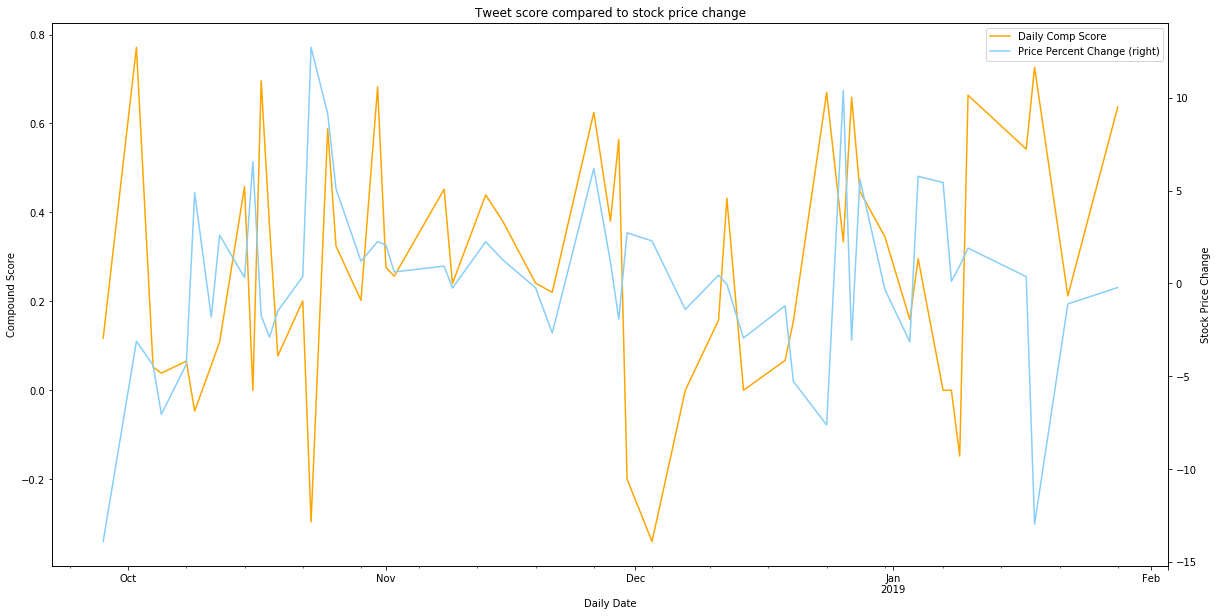

In [6]:
fig= plt.figure(figsize=(20,10))
ax=fig.gca()
cx=x.plot(kind='line',x='Daily Date',y='Daily Comp Score',ax=ax,color='orange')
bx=x.plot(kind='line',x='Daily Date',y='Price Percent Change',secondary_y=True,ax=ax,color='lightskyblue')
cx.set_ylabel('Compound Score')
bx.set_ylabel('Stock Price Change')
plt.title('Tweet score compared to stock price change')
plt.xlabel('Date')
plt.show()

R-Value:  -0.14970168085592125
P-Value:  0.28466420220610145
Standard Error:  2.4478189982284
R-Squared Value:  0.0224105932510881
Slope:  -2.6467493945513128


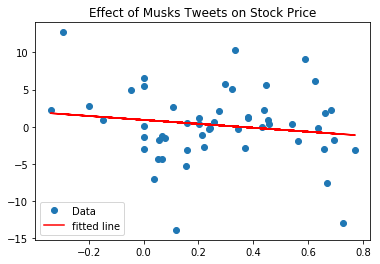

In [7]:
xx= x['Daily Comp Score']
yy= x['Price Percent Change']
slope, intercept, r_value, p_value, std_err = stats.linregress(xx,yy)
print("R-Value: ", r_value)
print("P-Value: ", p_value)
print("Standard Error: ", std_err)
print("R-Squared Value: ", r_value**2)
print("Slope: ", slope)
plt.title('Effect of Musks Tweets on Stock Price')
plt.plot(xx, yy, 'o', label='Data')
plt.plot(xx, intercept + slope*xx, 'r', label='fitted line')
plt.legend()
plt.show()

In [8]:
buy_sell = x.iloc[0, 1]
x_intercept = -intercept/slope
if slope < 0:
    if buy_sell > x_intercept:
        print("Given a most recent tweet score of more than {} our recommendation is to sell!".format(round(x_intercept,2)))
    elif buy_sell < x_intercept:   
        print("Given a most recent tweet score of less than {} our recommendation is to buy!".format(round(x_intercept,2)))
    else:                  
        print("Given a most recent tweet score of {} our recommendation is to hold!".format(round(x_intercept,2)))
else:
    if buy_sell > x_intercept:
        print("Given a most recent tweet score of more than {} our recommendation is to buy!".format(round(x_intercept,2)))
    elif buy_sell < x_intercept:   
        print("Given a most recent tweet score of less than {} our recommendation is to sell!".format(round(x_intercept,2)))
    else:                  
        print("Given a most recent tweet score of {} our recommendation is to hold!".format(round(x_intercept,2)))

Given a most recent tweet score of more than 0.35 our recommendation is to sell!


In [ ]:
# Building Web Application

df = tesla_df
app = dash.Dash(__name__) 

app.layout = html.Div(children=[
    html.H1('Stock Tickers'),
    dcc.Dropdown(
        id='my-dropdown',
        options=[
            {'label': 'Tesla', 'value': 'TSLA'},
            {'label': 'Ford', 'value': 'F'},
            {'label': 'General Motors', 'value': 'GM'}
        ],
        value='TSLA'
    ),
    dcc.Graph(id='my-graph'),
    
    html.H1(children='Elon Musks Tweet Scores vs. Tesla Stock Prices'),
    dcc.Graph(
        id ='musk-effect',
        figure={
            'data': [
                go.Scatter(
                    x=df['Daily Comp Score'],
                    y=df['Price Percent Change'],
                    mode='markers',
                    opacity=0.7,
                    marker={
                        'size': 15,
                        'line': {'width': 0.5, 'color': 'white'}
                    },
                )
            ],

            'layout': go.Layout(
                xaxis={'type': 'log', 'title': 'Daily Twitter Composite Score'},
                yaxis={'title': 'Price Percent Change'},
                margin={'l': 40, 'b': 40, 't': 10, 'r': 10},
                legend={'x': -1, 'y': 1},
                hovermode='closest'
            )
        }
)])

@app.callback(Output('my-graph', 'figure'), [Input('my-dropdown', 'value')])
def update_graph(selected_dropdown_value):
    df = web.DataReader(
        selected_dropdown_value, data_source='iex',
        start=datetime.datetime(2017, 1, 1), end=datetime.datetime.now())
    return {
        'data': [{
            'x': df.index,
            'y': df.close
        }]
    }


if __name__ == '__main__':
    app.run_server(debug=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [31/Jan/2019 13:01:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2019 13:01:13] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2019 13:01:13] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2019 13:01:14] "GET /_favicon.ico HTTP/1.1" 200 -
127.0.0.1 - - [31/Jan/2019 13:01:14] "POST /_dash-update-component HTTP/1.1" 200 -
